# Concept Description:
Our team's goal is to perform data analysis on the comments sections of reddit. Our initial plan is to extract data from various Reddit comments sections. Given the data we have, we will be use *Naive Bayes* to make a predictive analysis on the amount of upvotes a post receives, comparing it with *k-Nearest Neighbor* and *Support Vector Machines*.

# Data Collection:
Data was collected from https://github.com/linanqiu/reddit-dataset. In this repository, 50 csv files containing reddit comment section datasets are available with a free use policy granted by Linanqiu. The repo notes this was scraped by another of their tools, `omega-red`.

\pagebreak

# Example Description:

![Reddit post example](img/posts.png) 

Most of the data here is pretty well laid out, the initial repo put it pretty well, so we will be using that for the most part(some adaptations for our project):


The `.csv`s are named `<metareddit>_<subreddit>.csv`. The headers are described here and in `headers.txt`.


- `text`: Text of the comment / thread
- `id`: Unique reddit id for the comment / thread
- `subreddit`: Subreddit that the comment / thread belongs to
- `meta`: Metareddit that the comment / thread belongs to. Subreddits belong to metareddits. A subreddit can be `leagueoflegends`. The metareddit for that subreddit would be `gaming`, which can also include the subreddit `dota2`. **This is an arbitrary distinction from omega-red, that we will not include in our analysis.**
- `time`: UNIX timestamp of the comment / thread
- `author`: Username of the author of the comment / thread
- `ups`: Number of upvotes the comment / thread received
- `downs`: Number of downvotes the comment / thread received
- `authorlinkkarma`: The author's link karma. [What is Link Karma?](https://www.reddit.com/r/NoStupidQuestions/comments/2idfhk/what_is_link_karma/)
- `authorkarma`: The author's karma. [Reddit FAQ](https://www.reddit.com/wiki/faq) explaining karma.
- `authorisgold`: Boolean indicator for the gold status of the user. `1` for gold users, `0` for non-gold (normal) users. [Reddit FAQ](https://www.reddit.com/wiki/faq) explaining gold status.


\pagebreak

# Data Import and Wrangling:
The data from Linanqiu's data set was pretty thoroughly cleaned - there is no punctuation in the text and all letters are lowercase. However, the column names weren't quite helpfully named and some had inconsistent indexing - some start from 1, others started from 0. We then ran the following code to accomplish this:

In [6]:
from os import listdir, path, makedirs
import pandas as pd
import numpy as np

#Pandas setup
data_files = []
dataframes = []

#Clean directory dirs
data_dir = "../src-data"
out_dir = "processed-data"

if not path.exists(out_dir):
    makedirs(out_dir)


#Go through each file and process them columns
for filename in listdir(data_dir):
    has_idx = True
    file_list = filename.split('.')
    if(len(file_list) > 1):
        if filename.split('.')[1] == 'csv':
            data_files.append(filename)
            df_temp = (pd.read_csv(data_dir + '/' + filename))
            df_temp.drop([0], inplace=True)
            df_temp.drop(columns="Unnamed: 0", inplace=True)
            #There may be a more elegant way to do this check but this will suffice.
            for idx,row in enumerate(df_temp['0']):
                if(row != idx):
                    has_idx = False
            if(has_idx == True):
                #There may also be a more elegant way to do this rename.
                df_temp.rename(columns={
                    "1":"text", 
                    "2":"id", 
                    "3":"subreddit", 
                    "4":"meta", 
                    "5":"time", 
                    "6":"author", 
                    "7":"ups", 
                    "8":"downs", 
                    "9":"authorlinkkarma", 
                    "10":"authorkarma", 
                    "11":"authorisgold"
                }, inplace=True)
                df_temp.drop(columns="0")
            df_temp.rename(columns={
                "0":"text", 
                "1":"id", 
                "2":"subreddit", 
                "3":"meta", 
                "4":"time", 
                "5":"author", 
                "6":"ups", 
                "7":"downs", 
                "8":"authorlinkkarma", 
                "9":"authorkarma", 
                "10":"authorisgold"
            }, inplace=True)
            df_temp.to_csv(out_dir + '/' + filename, index=False)
            dataframes.append(df_temp)

In [7]:
# combine the data
%run -i 'combinedata.py'


KeyboardInterrupt: 

\pagebreak

# Exploratory Data Analysis:

For an initial visualization, we'll write some code to go through the texts and generate some wordclouds:


truereddit


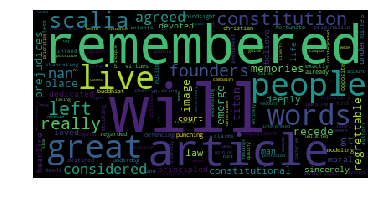

skyrim


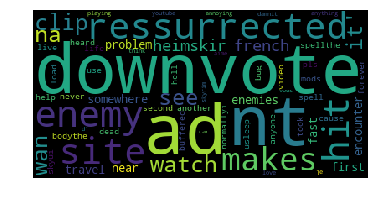

politics


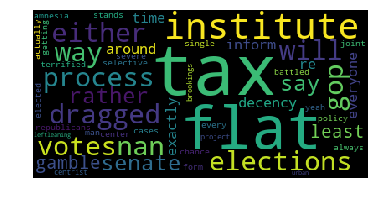

funny


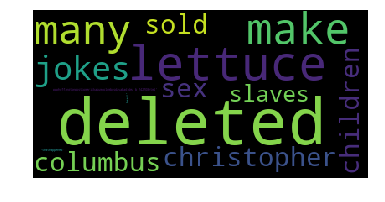

community


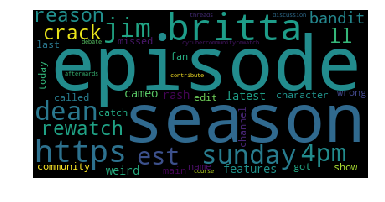

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
for dataframe in dataframes[:5]:
    text = (dataframe['text'].values)
    wordcloud = WordCloud().generate(str(text))
    print(dataframe['subreddit'].values[0])
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

Then, we filtered based off of those with an upvote count higher than 50.

This process revealed some markedly different results.

truereddit


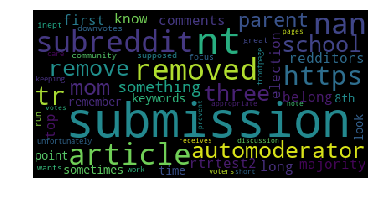

skyrim


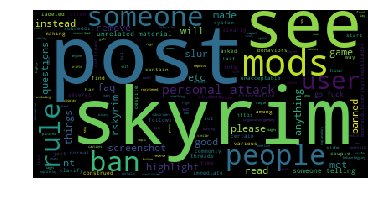

politics


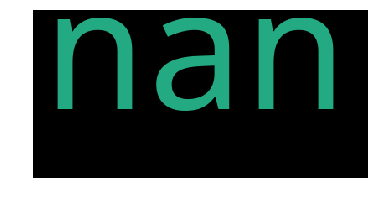

funny


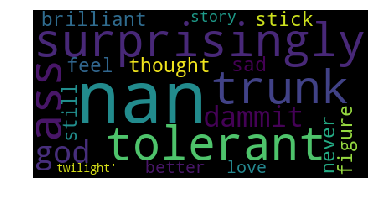

community


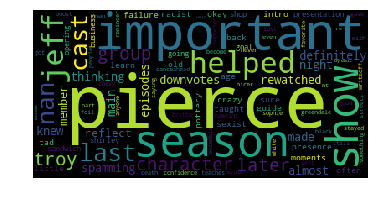

In [9]:
for dataframe in dataframes[:5]:
    text = (dataframe.loc[dataframe['ups'] > 50]['text'].values)
    wordcloud = WordCloud().generate(str(text))
    print(dataframe['subreddit'].values[0])
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

This shows that there may be some further data considerations - what about the `[deleted]` posts? What is going on with 'nan' / 'spoiler'? These are going to yield some interesting ramifications for our analysis stage.

Additionally, there are remnants of contractions, such as "nt", that we probably need to clean up, as well as "https" from links.

## Naive Bayes

Accuracy Score:  0.8609102458107318
Precision Score:  0.8544006114410018
Recall Score:  0.8162491574926982


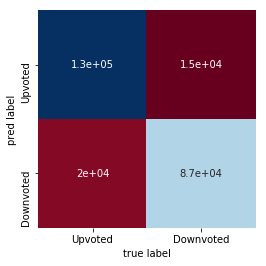

In [23]:
#import libraries

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns


#import the dataset
df = pd.read_csv("../processed-data/combined_csv.csv",dtype=str)

#drop columns where text is empty, not helpful
df.dropna(subset = ["text"],inplace=True)

#if the comment has positive ups, upvoted=true, else upvoted=false
df["upvoted"] = df["ups"].astype(float).apply(lambda x: 0 if x <= 2 else 1)

#split into train/test set
x_train,x_test,y_train,y_test = train_test_split(df['text'],df['upvoted'],random_state=1)

#create a vector of word counts 
cv = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', lowercase=True, stop_words='english')

#transform the x_set into vectors
x_train_cv = cv.fit_transform(x_train)
x_test_cv = cv.transform(x_test)

#use the multinomial naive bayes classifer to predict
nb = MultinomialNB()
nb.fit(x_train_cv,y_train)
pred = nb.predict(x_test_cv)

cm = confusion_matrix(y_test, pred)
sns.heatmap(cm,square=True,annot=True,cmap='RdBu', cbar=False, xticklabels=['Upvoted','Downvoted'],yticklabels=['Upvoted','Downvoted'])
plt.xlabel('true label')
plt.ylabel('pred label')


#print the accuracy of the model
print('Accuracy Score: ', accuracy_score(y_test,pred))
print('Precision Score: ', precision_score(y_test,pred))
print('Recall Score: ', recall_score(y_test,pred))



## Support Vector Machines

Accuracy Score:  0.9708616482829545
Precision Score:  0.9842095539976858
Recall Score:  0.9475679622556729


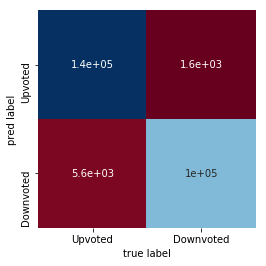

In [24]:
#import libraries

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns


#import the dataset
df = pd.read_csv("../processed-data/combined_csv.csv",dtype=str)

#drop columns where text is empty, not helpful
df.dropna(subset = ["text"],inplace=True)

#if the comment has positive ups, upvoted=true, else upvoted=false
df["upvoted"] = df["ups"].astype(float).apply(lambda x: 0 if x <= 2 else 1)

#split into train/test set
x_train,x_test,y_train,y_test = train_test_split(df['text'],df['upvoted'],random_state=1)

#create a vector of word counts 
cv = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', lowercase=True, stop_words='english')

#transform the x_set into vectors
x_train_cv = cv.fit_transform(x_train)
x_test_cv = cv.transform(x_test)

#use the support vector machine-based classifier (SVC) to predict
SV = SVC()
SV.fit(x_train_cv,y_train)
pred = SV.predict(x_test_cv)

cm = confusion_matrix(y_test, pred)
sns.heatmap(cm,square=True,annot=True,cmap='RdBu', cbar=False, xticklabels=['Upvoted','Downvoted'],yticklabels=['Upvoted','Downvoted'])
plt.xlabel('true label')
plt.ylabel('pred label')


#print the accuracy of the model
print('Accuracy Score: ', accuracy_score(y_test,pred))
print('Precision Score: ', precision_score(y_test,pred))
print('Recall Score: ', recall_score(y_test,pred))



Accuracy Score:  0.9898610634994253
Precision Score:  0.979449173760641
Recall Score:  0.9704685732430984


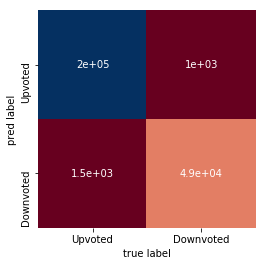

In [22]:
#import libraries

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier


#import the dataset
df = pd.read_csv("../processed-data/combined_csv.csv",dtype=str)

#drop columns where text is empty, not helpful
df.dropna(subset = ["text"],inplace=True)

#if the comment has positive ups, upvoted=true, else upvoted=false
df["upvoted"] = df["ups"].astype(float).apply(lambda x: 0 if x <= 10 else 1)

#split into train/test set
x_train,x_test,y_train,y_test = train_test_split(df['text'],df['upvoted'],random_state=1)

#create a vector of word counts 
cv = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', lowercase=True, stop_words='english')

#transform the x_set into vectors
x_train_cv = cv.fit_transform(x_train)
x_test_cv = cv.transform(x_test)

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train_cv,y_train)
pred = knn.predict(x_test_cv)
cm = confusion_matrix(y_test, pred)
sns.heatmap(cm,square=True,annot=True,cmap='RdBu', cbar=False, xticklabels=['Upvoted','Downvoted'],yticklabels=['Upvoted','Downvoted'])
plt.xlabel('true label')
plt.ylabel('pred label')


#print the accuracy of the model
print('Accuracy Score: ', accuracy_score(y_test,pred))
print('Precision Score: ', precision_score(y_test,pred))
print('Recall Score: ', recall_score(y_test,pred))


# Mining or Analytics:
Record any mining or analytics techniques you perform. This may include visualizations.

# Evaluation:
Record the evaluation of your mining or analytics techniques.

# Results:
Record the results of your findings.

# References

- https://www.pewresearch.org/wp-content/uploads/sites/8/2016/02/PJ_2016.02.25_Reddit_FINAL.pdf 
- https://ieeexplore.ieee.org/document/8622535 
- https://github.com/linanqiu/reddit-dataset 
- https://stackoverflow.com/questions/39870642/matplotlib-how-to-plot-a-high-resolution-graph 
- https://stackoverflow.com/questions/43606339/generate-word-cloud-from-single-column-pandas-dataframe
- https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html
- https://github.com/linanqiu/omega-red
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
- https://towardsdatascience.com/building-a-k-nearest-neighbors-k-nn-model-with-scikit-learn-51209555453a


# Future Work

### Part I: Update Our Dataset

The source we used to collect our data is creddited to github user Linanqiu. As provided, a set of 50 .csv files of various subreddits allowed us to create a predictive model for the likelihood of a post to be upvoted. These .csv files were collected in 2016, and the data from some of these .csvs is dated because the subreddit was either archived or deleted. In order to see if our predictive model retains accuracy with current events, we would initially begin with collecting updated data using Linanqiu's `omega-red` scraper. 

`Omega-red` is an aggressive rate-limit disobeying scraper specific to reddit. Using javascript, the scraper uses subreddits collected from a config file and approximates the number of threads in each subreddit. It then uses a buffered write stream to write the data into two .csv files: threads.csv and comments.csv. The data includes attributes such as text, id, subreddit, meta, time, ups, downs, authorlinkkarma, authorcommentkarma, and authorisgold.

In order to run the scraper, the node.js runtime environment is required. A number of dependencies is also required, but can easily be downloaded with npm, which is a package manager included in node.js. After the initial setup, the scraper can be run and the .csvs will be generated. The new dataset will then need to be wrangled similar to our original data to add in column names and deal with 'deleted', 'nan', and 'spoiler' comments. 

Our new dataset will consist of a single, comments.csv instead of divided into .csvs by subreddit. This will make running analysis on the data much easier than before. 

